<a href="https://colab.research.google.com/github/lovnishverma/Python-Getting-Started/blob/main/Dimensionality_Reduction_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality Reduction & Miscellaneous
## Part 1: Dimensionality Reduction Techniques (PCA, LDA, ICA)

**Instructor:** Lovnish Verma

**Topic:** Dimensionality Reduction  

---

### Learning Objectives
1.  **Understand** the "Curse of Dimensionality" and why we need reduction.
2.  **Master PCA** (Unsupervised): Preserving variance.
3.  **Master LDA** (Supervised): Maximizing class separability.
4.  **Master ICA** (Unsupervised): Blind source separation (the "Cocktail Party" problem).
5.  **Compare** these techniques on real and synthetic data.

---

## 1. Setup and Environment
We will use `scikit-learn` for the algorithms and `matplotlib`/`seaborn` for visualization.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris, make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

# Set plotting style for research-quality figures
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Environment Setup Complete.")

Environment Setup Complete.


## 2. Principal Component Analysis (PCA)

### Theory for Beginners
Imagine taking a photo of a teapot. You want to rotate the teapot so the photo captures the "widest" view, showing the most detail. PCA does exactly this for data: it rotates the dataset to find the angle (Principal Component) with the maximum **variance** (spread).

### Theory for Experts
PCA performs an orthogonal linear transformation that transforms the data to a new coordinate system.
* **First PC:** Direction of greatest variance.
* **Second PC:** Direction of second greatest variance, *orthogonal* to the first.
* **Mathematically:** We compute the **Covariance Matrix** of the data and find its **Eigenvectors** (directions) and **Eigenvalues** (magnitude of variance).

Let's apply this to the **Iris Dataset**.

# Mathematical Deep Dive: Computing the Covariance Matrix

Feature Covariance Matrix:

                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           0.685694         -0.042434           1.274315   
sepal width (cm)           -0.042434          0.189979          -0.329656   
petal length (cm)           1.274315         -0.329656           3.116278   
petal width (cm)            0.516271         -0.121639           1.295609   

                   petal width (cm)  
sepal length (cm)          0.516271  
sepal width (cm)          -0.121639  
petal length (cm)          1.295609  
petal width (cm)           0.581006  


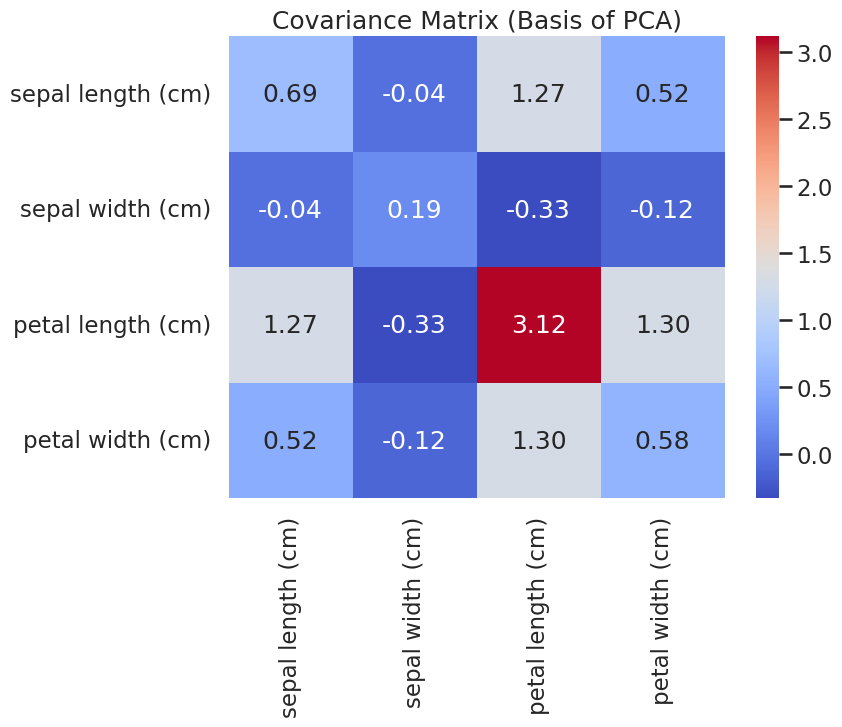

In [ ]:
# Load Iris Dataset
iris = load_iris()

# Convert to DataFrame
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)

# Compute Covariance Matrix
cov_matrix = df_iris.cov()

# Print Covariance Matrix
print("Feature Covariance Matrix:\n")
print(cov_matrix)

# Heatmap Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Covariance Matrix (Basis of PCA)')
plt.show()


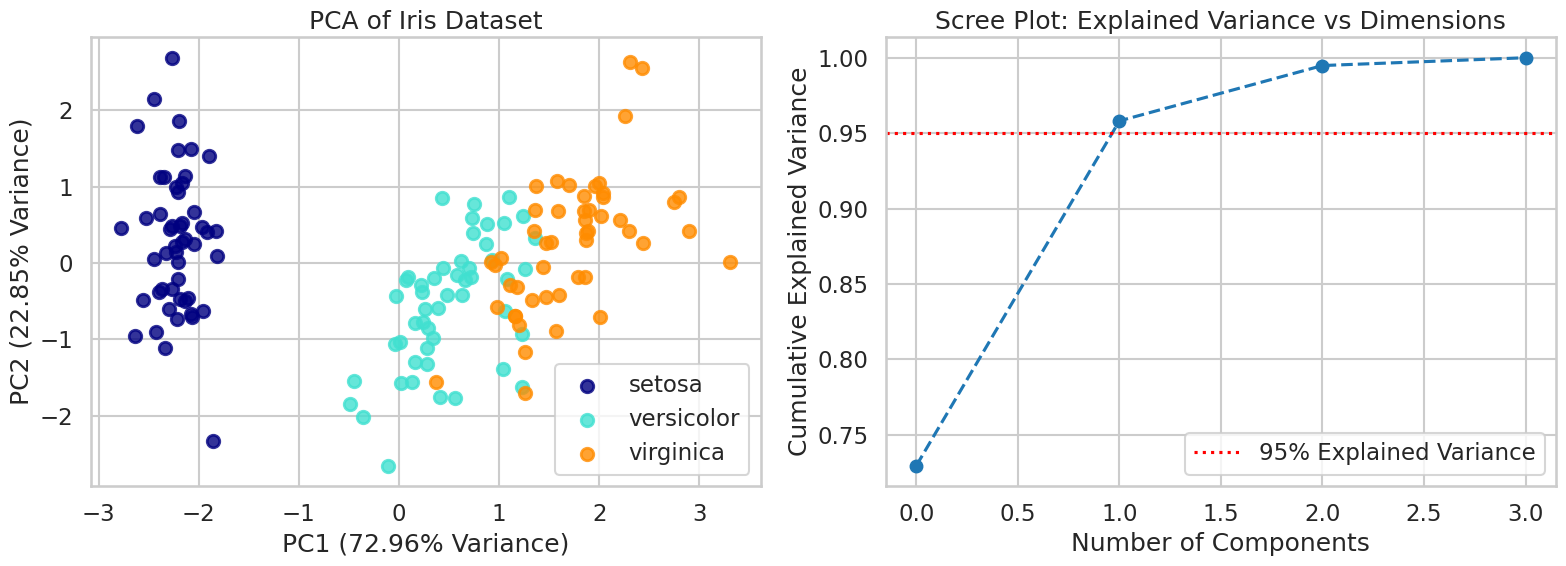

In [ ]:
def plot_pca_analysis():
    # 1. Load Data
    iris = load_iris()
    X = iris.data
    y = iris.target
    target_names = iris.target_names

    # 2. Standardize Data (CRITICAL for PCA)
    # PCA is sensitive to scale. If one feature is measured in km and another in cm,
    # the km feature will dominate variance.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. Apply PCA
    pca = PCA(n_components=2) # Project down to 2 dimensions
    X_r = pca.fit_transform(X_scaled)

    # 4. Visualization
    plt.figure(figsize=(16, 6))

    # Subplot 1: The 2D Projection
    plt.subplot(1, 2, 1)
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target_name)

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of Iris Dataset')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance)')

    # Subplot 2: Explained Variance (Scree Plot)
    # This helps us decide "How many dimensions do we actually need?"
    pca_full = PCA().fit(X_scaled)
    plt.subplot(1, 2, 2)
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot: Explained Variance vs Dimensions')
    plt.axhline(y=0.95, color='r', linestyle=':', label='95% Explained Variance')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_pca_analysis()

### Key Takeaway
Notice in the Left plot how the classes are somewhat separated, but there is overlap between Versicolor and Virginica?

**Why?** PCA is **Unsupervised**. It does *not* know about the class labels (colors). It only cares about spreading the data out. If the classes overlap in the direction of maximum spread, PCA won't fix that.

## 3. Linear Discriminant Analysis (LDA)

### Theory for Beginners
If PCA is about "spreading out the data," LDA is about "separating the groups." LDA looks for a viewing angle where the distance between the *centers* of the groups is maximized, while the spread *within* each group is minimized.

### Theory for Experts
LDA is a **Supervised** dimensionality reduction technique. It attempts to maximize the ratio of **Between-Class Scatter ($S_B$)** to **Within-Class Scatter ($S_W$)**.
* Objective: Maximize $J(w) = \frac{w^T S_B w}{w^T S_W w}$
* Constraint: The number of components is limited to $C - 1$ (where $C$ is the number of classes). For Iris (3 classes), we can find at most 2 LDA components.

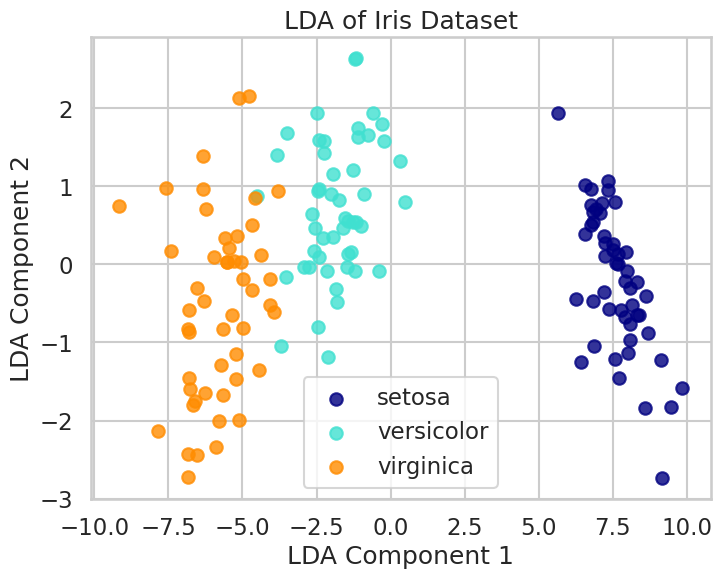

In [ ]:
def plot_lda_analysis():
    iris = load_iris()
    X = iris.data
    y = iris.target
    target_names = iris.target_names

    # LDA does not technically require scaling like PCA, but it's good practice.
    X_scaled = StandardScaler().fit_transform(X)

    # Apply LDA
    lda = LDA(n_components=2)
    X_r2 = lda.fit_transform(X_scaled, y) # Notice we pass 'y' here! Supervised!

    plt.figure(figsize=(8, 6))
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of Iris Dataset')
    plt.xlabel('LDA Component 1')
    plt.ylabel('LDA Component 2')
    plt.show()

plot_lda_analysis()

### Comparison: PCA vs. LDA
Compare the LDA plot above to the PCA plot earlier.
* **PCA:** Overlap between classes (focus on global structure).
* **LDA:** Clean separation between classes (focus on discrimination).

**When to use which?**
* Use **PCA** for data compression, visualization of unlabeled data, or noise reduction.
* Use **LDA** as a preprocessing step for classification tasks.

## 4. Independent Component Analysis (ICA)

### Theory for Beginners (The Cocktail Party Problem)
Imagine you are at a cocktail party with 3 distinct conversations happening simultaneously, and you have 3 microphones recording the room. Each microphone picks up a jumbled mix of all 3 conversations.

**ICA** is the magic algorithm that takes those 3 mixed recordings and un-mixes them back into the 3 original, clear conversations.

### Theory for Experts
PCA assumes data is Gaussian and uncorrelated. ICA assumes data is **Non-Gaussian** and **Independent**.
* It seeks a linear transformation $W$ such that the components of $S = WX$ are maximally independent (minimizing Mutual Information).
* It is often used in Signal Processing (EEG, Audio, Financial trends).

### Simulation
Since the Iris dataset doesn't fit the "mixed signal" analogy well, we will generate synthetic signals to demonstrate ICA.

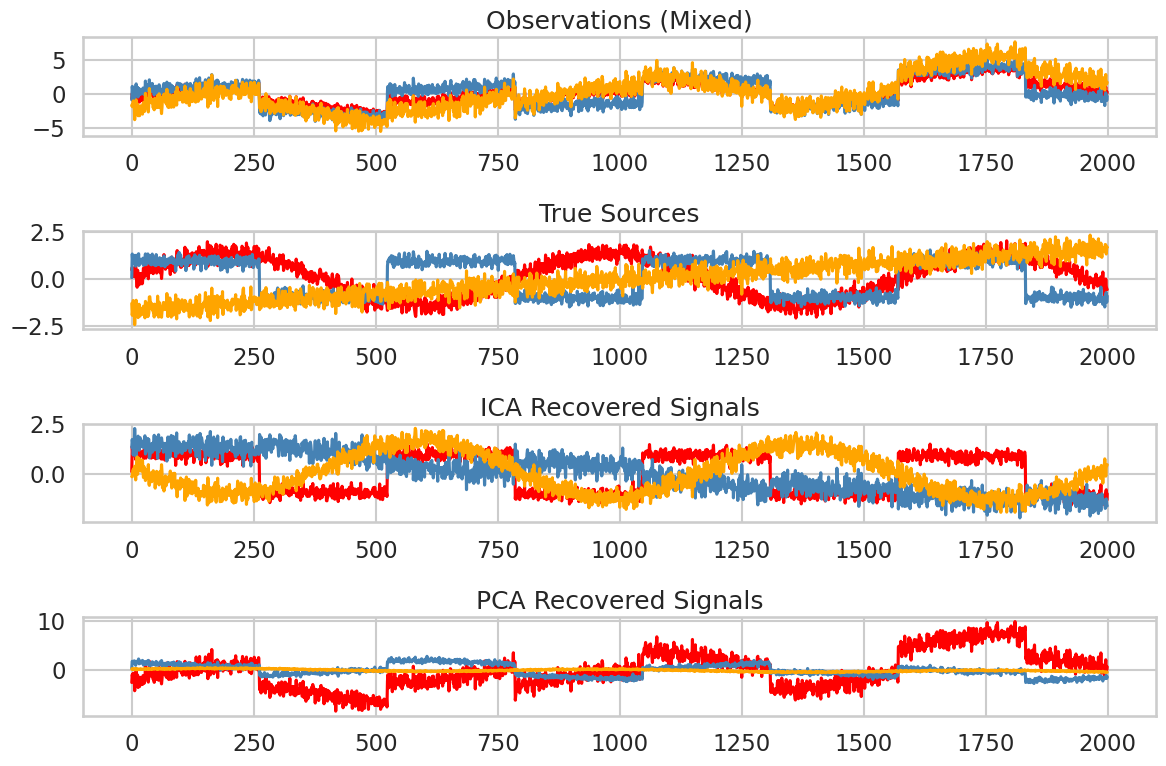

In [ ]:
def plot_ica_demo():
    # 1. Generate Sample Data (The "Sources")
    np.random.seed(0)
    n_samples = 2000
    time = np.linspace(0, 8, n_samples)

    # Signal 1: Sinusoidal
    s1 = np.sin(2 * time)
    # Signal 2: Square wave
    s2 = np.sign(np.sin(3 * time))
    # Signal 3: Sawtooth
    s3 = signal = np.linspace(0, 2, n_samples) - 1

    # Stack them
    S = np.c_[s1, s2, s3]
    # Add some noise
    S += 0.2 * np.random.normal(size=S.shape)

    # 2. Standardize data
    S /= S.std(axis=0)

    # 3. Mix the Signals (The "Microphones")
    # Mixing Matrix A
    A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])
    X = np.dot(S, A.T)  # X is the observed mixed signal

    # 4. Apply ICA to Recover
    ica = FastICA(n_components=3, whiten='unit-variance')
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Estimated mixing matrix

    # 5. Apply PCA for comparison
    # PCA fails here because it looks for orthogonal variance, not independence
    pca = PCA(n_components=3)
    H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

    # 6. Visualization
    plt.figure(figsize=(12, 8))

    models = [X, S, S_, H]
    names = ['Observations (Mixed)',
             'True Sources',
             'ICA Recovered Signals',
             'PCA Recovered Signals']
    colors = ['red', 'steelblue', 'orange']

    for ii, (model, name) in enumerate(zip(models, names), 1):
        plt.subplot(4, 1, ii)
        plt.title(name)
        for sig, color in zip(model.T, colors):
            plt.plot(sig, color=color)

    plt.tight_layout()
    plt.show()

plot_ica_demo()

### Analysis of ICA Results
* **True Sources:** The clean Sine, Square, and Sawtooth waves.
* **Observations:** The jumbled mess your "microphones" heard.
* **ICA Recovered:** Almost perfect reconstruction of the original waves! (Note: ICA cannot recover the amplitude/sign, so waves might be flipped or scaled, but the *shape* is correct).
* **PCA Recovered:** Fails to separate the signals. It just produces orthogonal mixtures.

## 5. Module Summary & Next Steps

### Summary Table

| Feature | PCA | LDA | ICA |
| :--- | :--- | :--- | :--- |
| **Type** | Unsupervised | Supervised | Unsupervised |
| **Goal** | Maximize Variance | Maximize Class Separation | Maximize Independence |
| **Assumption** | Correlations, Gaussian | Gaussian Classes, Equal Covariance | Non-Gaussian, Independent |
| **Use Case** | Compression, Denoising | Classification Pre-processing | Audio Separation, EEG |

### Looking Ahead
Now that we understand how to handle high-dimensional data, we are ready to move on to more complex modeling techniques included in this module:

1.  **Gaussian Mixture Models (GMM):** A probabilistic extension of clustering (like soft K-Means) that assumes data is generated from a mixture of Gaussian distributions.
2.  **Introduction to Deep Learning:** Where we use Neural Networks to automatically learn feature representations (Autoencoders are a non-linear relative of PCA!).
3.  **NLP & Computer Vision:** Fields where high-dimensionality is the norm (pixel arrays, word embeddings) and reduction techniques are crucial.